In [122]:
import sklearn
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import copy #For deepcopy
import miceforest
from miceforest import ImputationKernel #Multivariate imputation technique for missing values
from miceforest import mean_match_shap 
from matplotlib import rcParams

from sklearn.preprocessing import StandardScaler

from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
from sklearn import svm

In [123]:
train = pd.read_csv('train.csv')


# Overview

## Basic

In [124]:
print('--- Shape ---  \ntrain : ', train.shape, '\ntest: ', test.shape)
print('--- Head ---\n', train.head())

print('--- Unique ---\n')
print('HomePlanet', train['HomePlanet'].unique())
print('CryoSleep', train['CryoSleep'].unique())
print('Destination', train['Destination'].unique())
print('VIP', train['VIP'].unique())

--- Shape ---  
train :  (8693, 14) 
test:  (4277, 15)
--- Head ---
   PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1

In [125]:
#Print column names, types and nulls
for elm in train:
    print(elm, ':', train[elm].dtypes, train[elm].isnull().sum())

PassengerId : object 0
HomePlanet : object 201
CryoSleep : object 217
Cabin : object 199
Destination : object 182
Age : float64 179
VIP : object 203
RoomService : float64 181
FoodCourt : float64 183
ShoppingMall : float64 208
Spa : float64 183
VRDeck : float64 188
Name : object 200
Transported : bool 0


## Plots

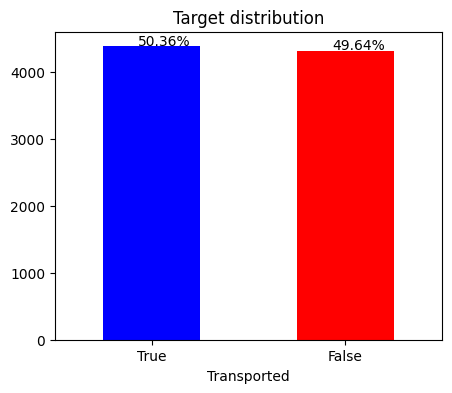

In [126]:
# Get labels
labels = np.array(train['Transported'].value_counts())
labels = (labels / labels.sum(axis=0) * 100).round(decimals=2).astype(str)
labels = list(map(lambda x : x+'%', labels))

# Plot
train['Transported'].value_counts().plot(kind='bar', color=('blue', 'red'), figsize=(5,4))
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 0)
i = 0
for p in ax.patches:
    ax.annotate(str(labels[i]), (p.get_x() + 0.18, p.get_height() * 1.005))
    i =+ 1
plt.title('Target distribution')
plt.show()

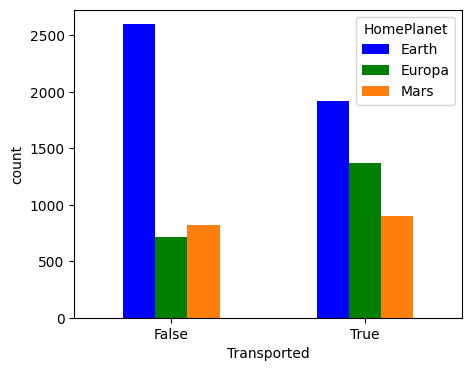

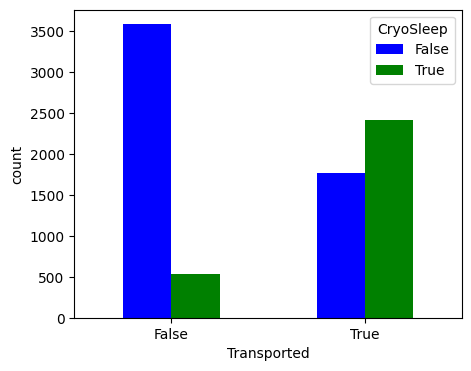

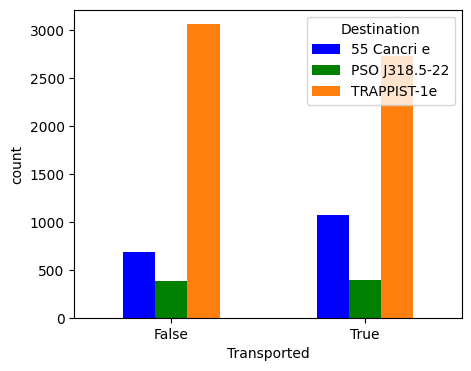

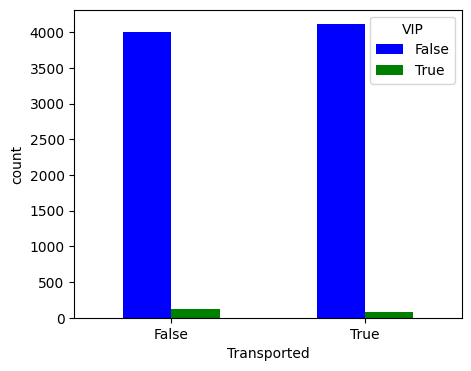

In [127]:
lst = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
for elm in lst:
    df_pivot = pd.pivot_table(
        train[["Age", "Transported", elm]],
        index="Transported",
        columns=elm,
        values=elm,
        aggfunc='count')

    fig, ax = plt.subplots()
    df_pivot.plot(kind="bar", ax=ax, color=['blue', 'green', 'tab:orange'], figsize=(5,4))
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylabel("count")
    plt.show()

## Correlation

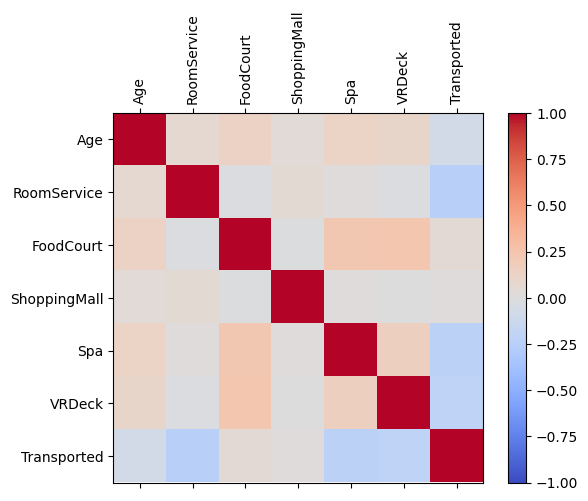

In [128]:
# Heatmap of correlation with numerical variables
df_num = train.select_dtypes(include = ['float64', 'int64', 'bool'])

corr = df_num.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_num.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_num.columns)
ax.set_yticklabels(df_num.columns)
plt.show()

In [129]:
train_ = copy.deepcopy(train)
train_ = train_.dropna()

In [130]:
corr_list = []
y = train_['Transported']

for col in df_num:
    if col == 'Transported': continue
    x=train_[col]
    corr = stats.pointbiserialr(list(x), list(y))
    corr_list.append((col, corr[0]))
print('Biserial correlation between feature and target')
print(corr_list)

Biserial correlation between feature and target
[('Age', -0.08255287690970185), ('RoomService', -0.24729078183708378), ('FoodCourt', 0.05502465048064445), ('ShoppingMall', 0.011601728883922267), ('Spa', -0.2198542639203347), ('VRDeck', -0.20794964666038265)]


# Preprocessing

### Feature enginnering

In [131]:
def featureEng(df):
    #Split Columns
    df[["temp", "Number"]] = df["PassengerId"].str.split("_", expand=True)
    df['Number'] = df['Number'].astype('Int64') #'n' -> n : n ∈ N
    df[["Deck", "CabinNum", "Side"]] = df["Cabin"].str.split("/", expand=True)
    #Drop columns
    df = df.drop(columns=["PassengerId"])
    df = df.drop(columns=["temp"])
    df = df.drop(columns=["Cabin"])
    df = df.drop(columns=["Name"])

    ### Group values
    #Cabin number is converted into categoriacal values
    df['CabinNum'] = df['CabinNum'].astype('Int64') #'n' -> n : n ∈ N
    # df['CabinNum'] = pd.cut(df['CabinNum'],bins=[0,250,500,750,1000,1250,1500],labels=['A', 'B', 'C', 'D', 'E', 'F'])

    #Age is converted into categoriacal values.
    df['Age'] = pd.cut(df['Age'],bins=[0,2,17, 35,65,99],labels=['Toddler','Child','Young adult','Adult','Elderly'])
    df['Spendings'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    
    ### convert categorical variable into Numeric numConverter()
    df['HomePlanet'] = pd.factorize(df['HomePlanet'])[0]
    df['CryoSleep'] = pd.factorize(df['CryoSleep'])[0]
    df['Destination'] = pd.factorize(df['Destination'])[0]
    df['Age'] = pd.factorize(df['Age'])[0]
    df['VIP'] = pd.factorize(df['VIP'])[0]
    df['Deck'] = pd.factorize(df['Deck'])[0]
    # df['CabinNum'] = pd.factorize(df['CabinNum'])[0]
    df['Side'] = pd.factorize(df['Side'])[0]
    df = df.replace(-1, np.NaN)
    return df
train = featureEng(train)

### Missing values

In [132]:
def removeNull(df):
    mice_kernel = ImputationKernel(
        data = df,
        save_all_iterations = True,
        random_state = 42)
    mice_kernel.mice(4)
    df_ = mice_kernel.complete_data()
    for elm in df_: df[elm] = df_[elm]
    return df
# train = removeNull(train)

In [133]:
def removeNull_1(df):
    df = df.fillna(df.mode().iloc[0])
    return df
# train = removeNull_1(train)

In [134]:
print('null count == ', train.loc[:, train.columns != "Name"].isna().sum().sum())
print(train.head())

null count ==  0
   HomePlanet  CryoSleep  Destination  Age  VIP  RoomService  FoodCourt  \
0         0.0        0.0          0.0  0.0  0.0          0.0        0.0   
1         1.0        0.0          0.0  1.0  0.0        109.0        9.0   
2         0.0        0.0          0.0  0.0  1.0         43.0     3576.0   
3         0.0        0.0          0.0  1.0  0.0          0.0     1283.0   
4         1.0        0.0          0.0  2.0  0.0        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported  Number  Deck  CabinNum  Side  \
0           0.0     0.0     0.0        False       1   0.0         0   0.0   
1          25.0   549.0    44.0         True       1   1.0         0   1.0   
2           0.0  6715.0    49.0        False       1   2.0         0   1.0   
3         371.0  3329.0   193.0        False       2   2.0         0   1.0   
4         151.0   565.0     2.0         True       1   1.0         1   1.0   

   Spendings  
0        0.0  
1      736.0  
2    10383.0  
3  

# Overview 2

 --- Zero percentage for RoomService --- 
True : 82.57%
False: 49.66%


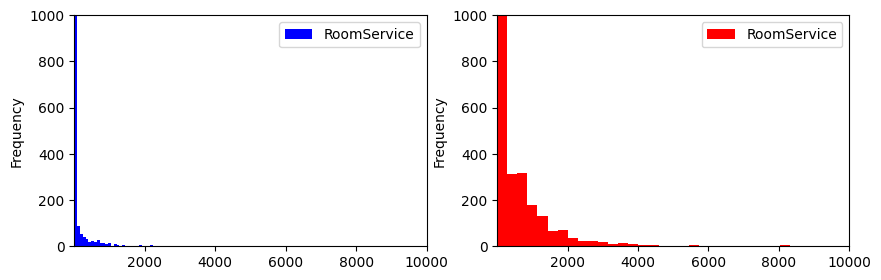

 --- Zero percentage for FoodCourt --- 
True : 75.9%
False: 53.67%


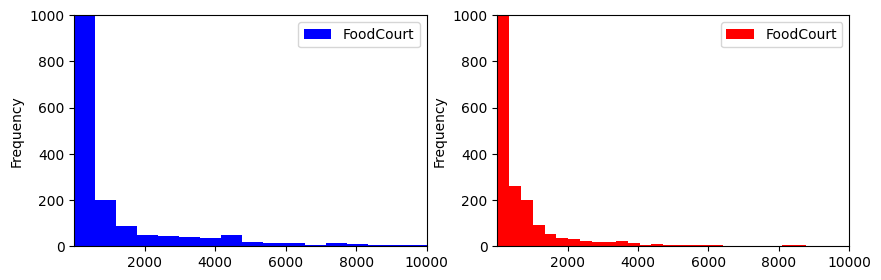

 --- Zero percentage for ShoppingMall --- 
True : 79.01%
False: 54.14%


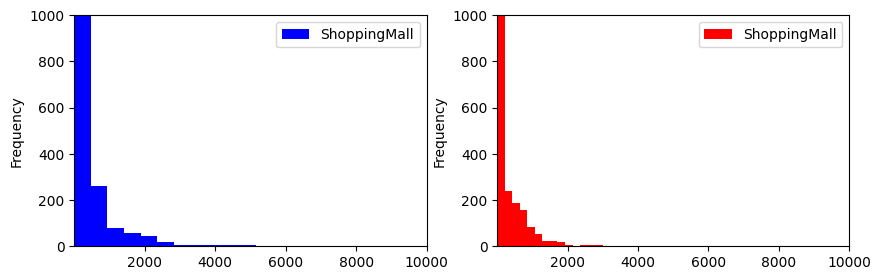

 --- Zero percentage for Spa --- 
True : 79.81%
False: 46.65%


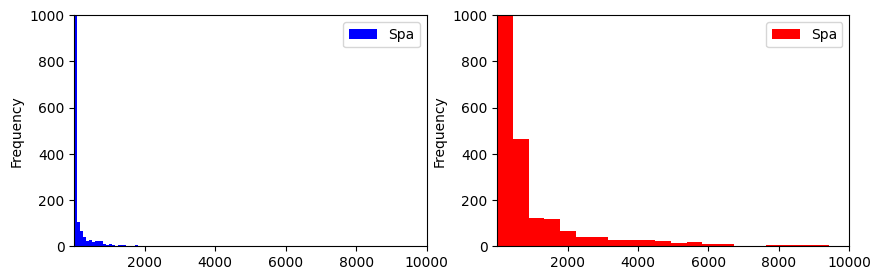

 --- Zero percentage for VRDeck --- 
True : 81.06%
False: 49.46%


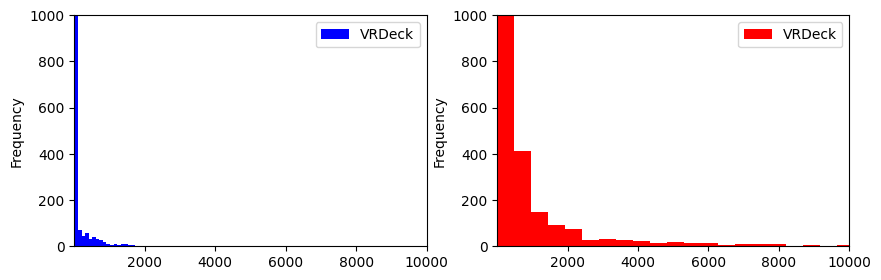

 --- Zero percentage for Spendings --- 
True : 68.78%
False: 26.51%


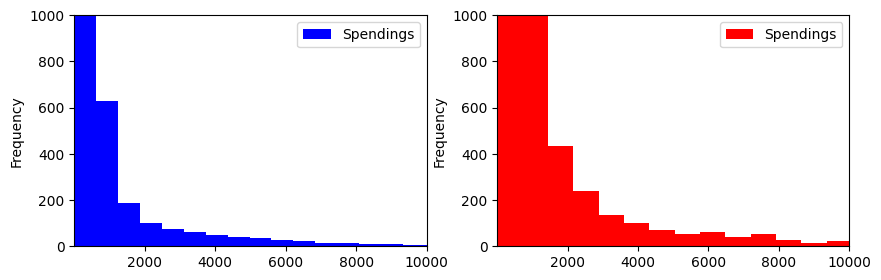

In [135]:
def getPerc(df, i):
    count = df[i].value_counts()[0]
    len = df.shape[0]
    return round((count / len) * 100, 2)

for elm in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Spendings']:
    df_ = train[['Transported', elm]]
    df_true = df_[df_['Transported'] == True]
    df_false = df_[df_['Transported'] == False]
    percTrue = getPerc(df_true, elm)
    percFalse = getPerc(df_false, elm)
    print(" --- Zero percentage for {} --- ".format(elm))
    print('True : ' + str(percTrue) + '%')
    print('False: ' + str(percFalse) + '%')


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))
    df_true.plot(kind="hist", ax=ax1, bins=50, ylim=[0,1000], xlim=[1,10000], color='blue')
    df_false.plot(kind="hist", ax=ax2, bins=50, ylim=[0,1000], xlim=[1,10000], color='red')
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylabel("count")
    plt.show()

# Preproccesing 2

In [136]:
# Convert categorial variables into binary dummy variables
def dummy(df):
    df = pd.get_dummies(df)
    return df
train = dummy(train)

In [137]:
def logTransform(df):
    df['Spendings'] = np.log1p(df['Spendings'])
    return df
train = logTransform(train)

<Axes: >

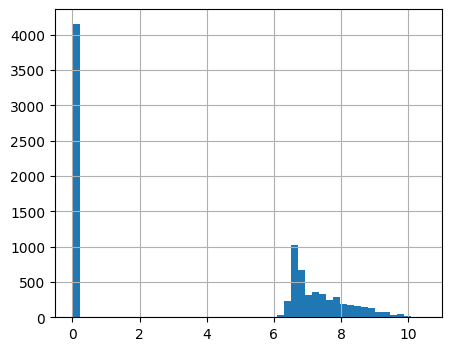

In [138]:
train['Spendings'].hist(figsize=(5,4), bins=50)

In [139]:
def scale(df):
    scaler = StandardScaler()
    df = scaler.fit_transform(df)
    return df

# Models

In [140]:
Xtrain, foo = train_test_split(train, test_size=0.2, shuffle=True, random_state = 42)
Xtest, Xval = train_test_split(foo, test_size=0.5, shuffle=True, random_state = 42)

Ytrain, Ytest, Yval = Xtrain.pop('Transported').astype(int), Xtest.pop('Transported').astype(int), Xval.pop('Transported').astype(int)
Xtrain, Xtest, Xval = scale(Xtrain), scale(Xtest), scale(Xval)

print('train: ' + str(Xtrain.shape), Ytrain.shape)
print('test: ' + str(Xtest.shape), Ytest.shape)
print('val: ' + str(Xval.shape), Yval.shape)

train: (6954, 15) (6954,)
test: (869, 15) (869,)
val: (870, 15) (870,)


### Logistic regression

Grid search for turning hyperparameters

In [141]:
# Grid search
def logRegGrid():
    parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear']},
                {'penalty':['none', 'l2']},
                {'C':[0.001, 0.01, 0.1, 1, 10]}]


    logreg = LogisticRegression(random_state=42, max_iter=1000)
    grid_search = GridSearchCV(estimator = logreg,  
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5,
                            verbose=0)
    grid_search.fit(Xval, Yval)
    print('Best hyperparameters:', grid_search.best_params_)
    print('Accuracy:', grid_search.best_score_) 

# logRegGrid()

In [142]:
clf = LogisticRegression(random_state=42, max_iter=1000, C=0.1, solver='lbfgs', class_weight = 'balanced', penalty='l2').fit(Xtrain, Ytrain)
pred = clf.predict(Xtest) 

In [143]:
print("LogisticRegression MSE:",metrics.mean_squared_error(Ytest, pred))
print("LogisticRegression Regression Accuracy:",metrics.accuracy_score(Ytest, pred)) 
print("LogisticRegression Regression Precision:",metrics.precision_score(Ytest, pred))
print("LogisticRegression Regression Recall:",metrics.recall_score(Ytest, pred))

LogisticRegression MSE: 0.21173762945914845
LogisticRegression Regression Accuracy: 0.7882623705408516
LogisticRegression Regression Precision: 0.758695652173913
LogisticRegression Regression Recall: 0.8270142180094787


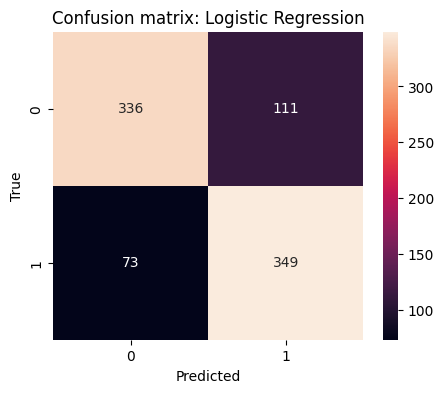

In [144]:
cm = metrics.confusion_matrix(Ytest, pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix: Logistic Regression')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [145]:
unique, counts = np.unique(pred, return_counts=True)
print(train['Transported'].value_counts())
print('\n',np.asarray((unique, counts)))

Transported
True     4378
False    4315
Name: count, dtype: int64

 [[  0   1]
 [409 460]]


# Advanced model

In [146]:
train_ = dummy(train)
Xtrain, foo = train_test_split(train_, test_size=0.2, shuffle=True, random_state = 42)
Xtest, Xval = train_test_split(foo, test_size=0.5, shuffle=True, random_state = 42)

Ytrain, Ytest, Yval = Xtrain.pop('Transported').astype(int), Xtest.pop('Transported').astype(int), Xval.pop('Transported').astype(int)
Xtrain, Xtest, Xval = scale(Xtrain), scale(Xtest), scale(Xval)

print('train: ' + str(Xtrain.shape), Ytrain.shape)
print('test: ' + str(Xtest.shape), Ytest.shape)
print('val: ' + str(Xval.shape), Yval.shape)

train: (6954, 15) (6954,)
test: (869, 15) (869,)
val: (870, 15) (870,)


In [147]:
# Grid search
'''
parameters = [
            {'min_samples_split':[2, 4, 6]},
            {'max_depth':[3, 5, 7]},
            {'n_estimators': [50, 100, 200, 300]},
            {'learning_rate': [0.1, 0.07, 0.05, 0.03]}
            ]

est = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = est,  
                        param_grid = parameters,
                        scoring = 'accuracy',
                        cv = 5,)
grid_search.fit(Xval, Yval)
print('Best hyperparameters:', grid_search.best_params_)
print('Accuracy:', grid_search.best_score_) 
'''

"\nparameters = [\n            {'min_samples_split':[2, 4, 6]},\n            {'max_depth':[3, 5, 7]},\n            {'n_estimators': [50, 100, 200, 300]},\n            {'learning_rate': [0.1, 0.07, 0.05, 0.03]}\n            ]\n\nest = GradientBoostingClassifier()\ngrid_search = GridSearchCV(estimator = est,  \n                        param_grid = parameters,\n                        scoring = 'accuracy',\n                        cv = 5,)\ngrid_search.fit(Xval, Yval)\nprint('Best hyperparameters:', grid_search.best_params_)\nprint('Accuracy:', grid_search.best_score_) \n"

In [148]:
clf = GradientBoostingClassifier(random_state=42, max_depth=5, min_samples_split=4, n_estimators=200, learning_rate=0.1).fit(Xtrain, Ytrain)
pred_ = clf.predict(Xtest) 

In [149]:
print("GradientBoostingClassifier MSE:",metrics.mean_squared_error(Ytest, pred_))
print("GradientBoostingClassifier Regression Accuracy:",metrics.accuracy_score(Ytest, pred_)) 
print("GradientBoostingClassifier Regression Precision:",metrics.precision_score(Ytest, pred_))
print("GradientBoostingClassifier Regression Recall:",metrics.recall_score(Ytest, pred_))

GradientBoostingClassifier MSE: 0.2186421173762946
GradientBoostingClassifier Regression Accuracy: 0.7813578826237054
GradientBoostingClassifier Regression Precision: 0.8694267515923567
GradientBoostingClassifier Regression Recall: 0.6469194312796208


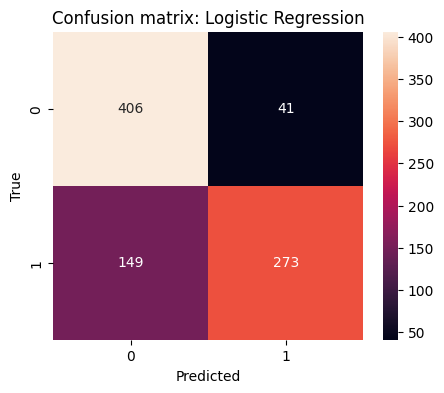

In [150]:
cm = metrics.confusion_matrix(Ytest, pred_)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix: Logistic Regression')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Evaluation

In [151]:
test = pd.read_csv('test.csv')
PassengerIds = test.PassengerId.values.tolist()
test = featureEng(test)
test = removeNull(test)
test = logTransform(test)
test = pd.DataFrame(test.values)
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,3,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,2823.0,0.0,1,1.0,4,0.0,7.949091
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2.0,0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,0.0,6652.0,0.0,181.0,585.0,1,2.0,1,0.0,8.9118
4,0.0,1.0,0.0,0.0,0.0,10.0,0.0,635.0,0.0,0.0,1,1.0,5,0.0,6.4708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,1496,0.0,0.0
4273,0.0,1.0,0.0,1.0,0.0,0.0,847.0,17.0,10.0,144.0,1,1.0,4,0.0,6.926577
4274,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4.0,296,1.0,0.0
4275,1.0,1.0,0.0,0.0,0.0,0.0,2680.0,0.0,0.0,523.0,1,4.0,297,1.0,8.072155


In [152]:
submission = clf.predict(test)
print(len(submission))
submission = list(map(bool,submission))
output = pd.DataFrame({'PassengerId':PassengerIds, 'Transported': submission}) 
output.to_csv('submission.csv', index = False) 

4277
